In [1]:
# Import essential packages
import wntr
import pickle
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pandas as pd

In [3]:
# "the default sans-serif font is Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14})

In [7]:
Wdn = wntr.network.WaterNetworkModel(r'Dtown_Backbone_Final.inp')

C:\Users\Zhouxiaomu\anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning: Not all curves were used in "Dtown_Backbone_Final.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


In [8]:
OWdn = wntr.network.WaterNetworkModel(r'D-town.inp')

In [24]:
print(len(OWdn.link_name_list), len(Wdn.link_name_list), len(OWdn.node_name_list), len(Wdn.node_name_list))

459 129 407 122


In [25]:
print((459-129)/459, (407-122)/407)

0.7189542483660131 0.7002457002457002


In [9]:
# Simulate for a stable period
Wdn.options.time.duration = 2 * 3600
Sim = wntr.sim.EpanetSimulator(Wdn)
Results = Sim.run_sim()

In [10]:
# Get the important indicators
Flow = Results.link['flowrate']
Head = Results.node['head']

**Build a directed graph for each time instant t**

In [11]:
# Build hourly hydraulic-informed directed graph 
def hourly_dgraph(wdn, flow, head, t): 
    # Initiated the directed graph
    dgraph = nx.DiGraph()
    # Use link (pipe, valve) diameter as the main selection criteria
    for name, link in wdn.links():
        # Determine the direction of edge through the flow rate, positive: as stored, negative: change direction
        linkflow = flow.loc[3600*t, name]
        # Only establish graph with nonzero flows
        if linkflow > 1e-8:
            start_node = link.start_node_name
            end_node = link.end_node_name
        elif linkflow < (-1e-8):
            start_node = link.end_node_name
            end_node = link.start_node_name
        edgelist = list(dgraph.edges)
        # Build corresponding original network
        # If there is already a link from start_node to end_node in the graph, then this is the parallel links (pumps)
        if (start_node, end_node) in edgelist:
            # Keep the existing flow 
            linkcapacity = dgraph[start_node][end_node]['capacity']
            dgraph.add_edge(start_node, end_node, linkid = name, capacity= linkcapacity + abs(linkflow), length=(head.loc[3600*t, start_node]-head.loc[3600*t, end_node]))
        else:
            dgraph.add_node(start_node, pos = wdn.get_node(start_node).coordinates)
            dgraph.add_node(end_node, pos = wdn.get_node(end_node).coordinates)
            dgraph.add_edge(start_node, end_node, linkid = name, capacity= abs(linkflow), length=(head.loc[3600*t, start_node]-head.loc[3600*t, end_node]))    
    return dgraph

In [12]:
T = 1
Dgraph = hourly_dgraph(Wdn, Flow, Head, T)

**Calculate the marginal energy intensity of all the nodes**

In [16]:
# Calculate the distance to source
def calculate_mei(sources, dgraph):
    nodes = list(dgraph.nodes)
    # junctions are nodes except for resevoirs
    junctions = [node for node in nodes if node not in sources]
    mei = {}
    r = {}
    h = {}
    meid = {}
    maximumdistance = {}
    # For each junction get their longest distance to each sources
    for i in sources:
        meid[i] = {}
        r[i] = {}
        h[i] = {}
        maximumdistance[i] = {}
        # Intialize the and rij, hij, meij
        r[i][i] = 1
        h[i][i] = 0
        meid[i][i]= 0
        for j in junctions:
            r[i][j] = 0
            h[i][j] = 0
            meid[i][j]= 0
            # Get the maximum distance between j and source i
            if nx.has_path(dgraph, i, j):
                paths = list(nx.all_simple_paths(dgraph, source=i, target=j))
                maximumd = 0
                for p in paths:
                    d = len(p)
                    if d > maximumd:
                        maximumd = d
                maximumdistance[i][j] = maximumd
        # Rank the nodes according to their maximum distance to the source
        nodetoevaluate = sorted(maximumdistance[i], key=maximumdistance[i].get)
        for j in nodetoevaluate:
            # Get its upstream nodes
            klist = list(dgraph.predecessors(j))
            qj = 0
            qkj = []
            hkj = []
            for ik in range(len(klist)):
                # Get the flow from k to j, which is the capacity established before
                qkj.append(dgraph[klist[ik]][j]['capacity'])
                # Get the head difference from k to j, which is the lenegth established before
                # Check if the head difference is negative, then it is a pump
                hd = dgraph[klist[ik]][j]['length']
                if hd < 0:
                    # Assume the mechanical efficiency to be 75% for all the pumps
                    hkj.append(abs(hd)/0.75)
                else:
                    hkj.append(hd)
            #if sum(qkj) < 1e-8:
                #rkj = np.array(qkj)/1e-8
            #else:
            qkj = np.array(qkj)
            rkj = qkj/sum(qkj)
            # The numerator and denomenator to calculate hij
            hnumerator = 0
            hdenomenator = 0
            for ik in range(len(klist)):
                r[i][j] += r[i][klist[ik]]*rkj[ik]
            for ik in range(len(klist)):
                hnumerator += (r[i][klist[ik]]*qkj[ik]*(h[i][klist[ik]]+hkj[ik]))
                hdenomenator += (r[i][klist[ik]]*qkj[ik])
            #if hdenomenator < 1e-8:
                # To avoid the case of zero
                #hdenomenator = 1e-8
            h[i][j] = (hnumerator/hdenomenator)
            # pghij, transfer the unit from jole to kwh
            meid[i][j] = 1e4*h[i][j]*2.7778e-7
    # Accumulate the marginal energy intensity from all sources
    for j in junctions:
        mei[j] = 0
        for i in sources:
            mei[j] += r[i][j]*meid[i][j]
    return mei, r

In [14]:
Sources = ['R1']

In [17]:
Mei, R = calculate_mei(Sources, Dgraph)

In [18]:
def mapnodeattribute(wdn, attribute):
    nodeattribute = []
    dx = []
    dy = []
    junctionlist = wdn.junction_name_list
    # Only show nodes that have estimated marginal energy intensity 
    nodelist = [junction for junction in junctionlist if junction in list(attribute.keys())]
    for node in nodelist: 
        # Get its demand
        value = attribute[node]
        nodeobject = wdn.get_node(node)
        nodeattribute.append(value)
        (x, y) = nodeobject.coordinates
        dx.append(x)
        dy.append(y)
    nodeattribute = np.array(nodeattribute)
    return nodeattribute, dx, dy

In [19]:
Nodemei, Dx, Dy = mapnodeattribute(Wdn, Mei)

In [20]:
def get_node_coordinate(wdn, node_list):
    node_x = []
    node_y = []
    for node in node_list:
        nodeobject = wdn.get_node(node)
        (x, y) = nodeobject.coordinates
        node_x.append(x)
        node_y.append(y)
    return node_x, node_y

In [21]:
# The three WTPs
WTPs = ['R1']
W_x, W_y = get_node_coordinate(OWdn, WTPs)

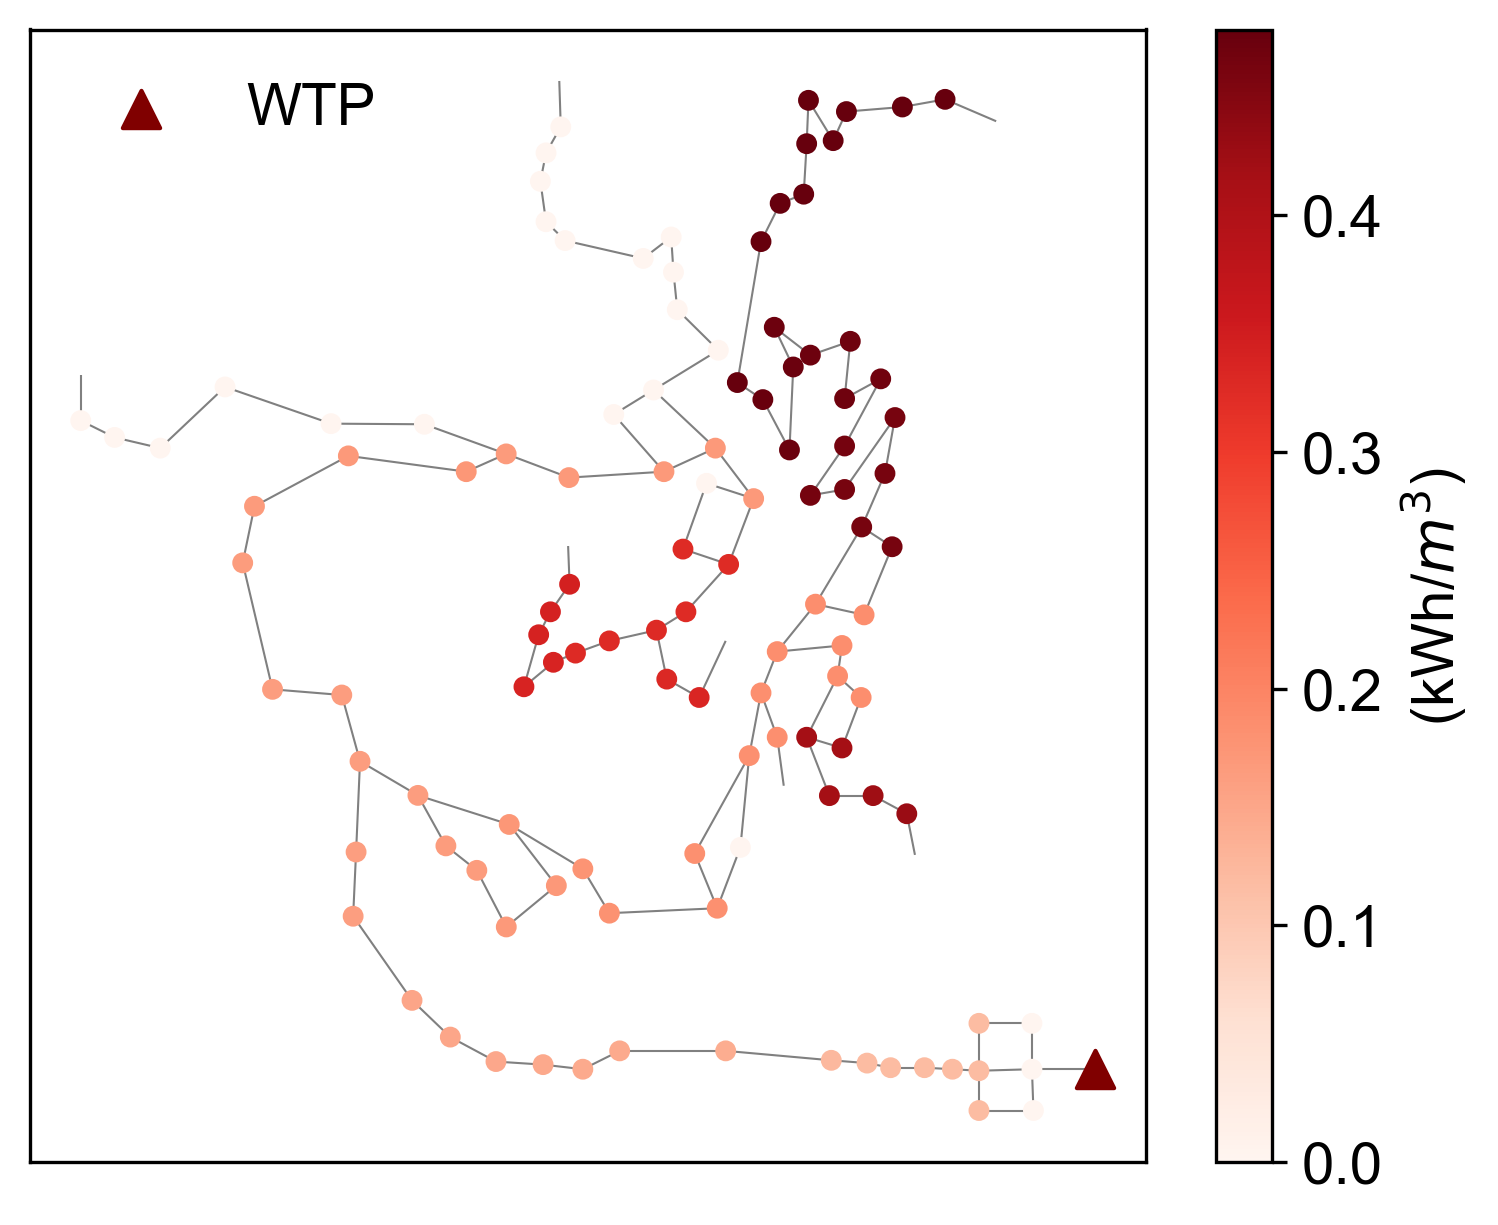

In [23]:
# Visualize the results
# Draw the whole network
G = Wdn.get_graph()
POS = nx.get_node_attributes(G,'pos')
nx.draw_networkx(G, pos=POS, arrows=False, with_labels=False, node_color='gray',
                 node_size = 0, width = 0.5, edge_color='gray')
# Make the corlor mapp
Vmin = np.min(Nodemei)
Vmax = np.max(Nodemei)
plt.scatter(Dx, Dy, s = 16, c = Nodemei, cmap = 'Reds', vmin = Vmin, vmax = Vmax)
plt.scatter(W_x, W_y, marker = "^", s = 80, c = 'maroon', label = 'WTP')
#plt.scatter(G_x, G_y, marker = "^", s = 40, c = 'darkorange', label = 'GWTP')
#plt.scatter(DPRPX, DPRPY, marker = "*", s = 60, c = 'seagreen', label = 'DPRP')
# Make the legend
plt.legend(frameon=False, loc = 'upper left')
Sm1 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=Vmin, vmax = Vmax))
Sm1.set_array([])
plt.xticks([])
plt.yticks([])
cbar1 = plt.colorbar(Sm1, label='(kWh/$m^3$)')
plt.rcParams['figure.figsize'] = (6, 5) 
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 
plt.savefig(r"Dtown_Backbone_Mei_7am.jpg", bbox_inches='tight')
plt.show()

In [27]:
FMei = open('MEI.pickle', 'wb')
pickle.dump(Mei, FMei)
FMei.close()